Results from SCARGC algorithm (for boxplot and accuracy timelime).
Keyboard patterns database. 10 features. 4 classes.
Stream mode with pool size = 150



METHOD: Static knn as classifier
Execution time:  0.3738748152593322
Average error: 28.67625
Average micro-F1: 0.828125
Average Accuracy:  71.32375
Standard Deviation:  12.5322682878
Variance:  157.057748438


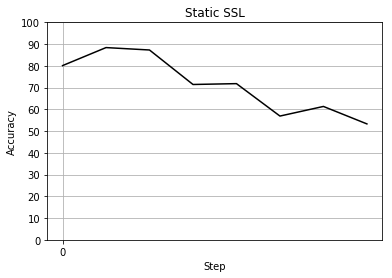

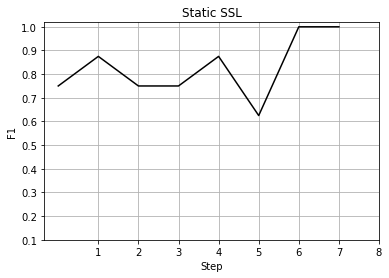




METHOD: Sliding knn as classifier


C:\Users\raul\Desktop\GITHUB\Systems-Engineering\Dissertation\source\classifiers.py:135: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return KNeighborsClassifier(n_neighbors=K, algorithm = 'brute').fit(X, y)


Execution time:  0.468881197479033
Average error: 22.33875
Average micro-F1: 0.796875
Average Accuracy:  77.66125
Standard Deviation:  5.65636684962
Variance:  31.9944859375


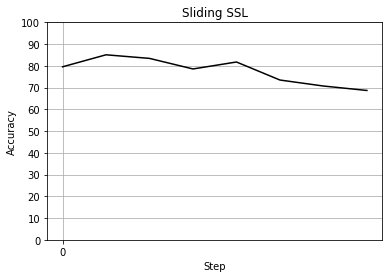

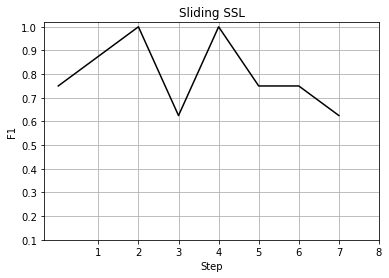




METHOD: Incremental knn as classifier
Execution time:  1.1294822204514685
Average error: 12.48375
Average micro-F1: 0.921875
Average Accuracy:  87.51625
Standard Deviation:  2.48199988668
Variance:  6.1603234375


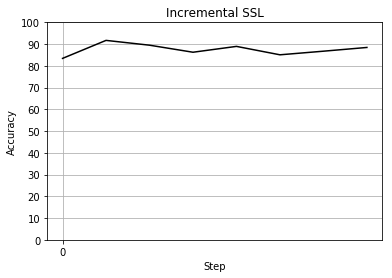

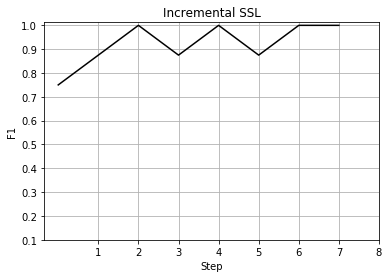




METHOD: knn as classifier and kde as core support extraction with cutting data method
Execution time:  0.4663903342655473
Average error: 10.69125
Average micro-F1: 0.890625
Average Accuracy:  89.30875
Standard Deviation:  3.55354202698
Variance:  12.6276609375


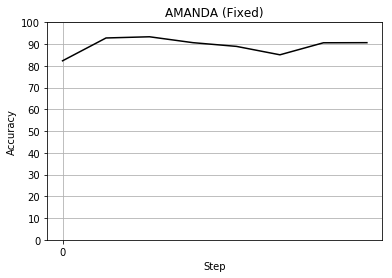

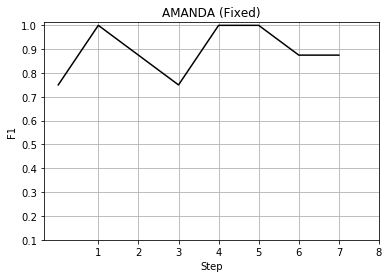




METHOD: knn as classifier and kde and Hellinger distance as dynamic CSE
Execution time:  20.855423266993277
Average error: 10.965
Average micro-F1: 0.921875
Average Accuracy:  89.035
Standard Deviation:  2.98474035722
Variance:  8.908675


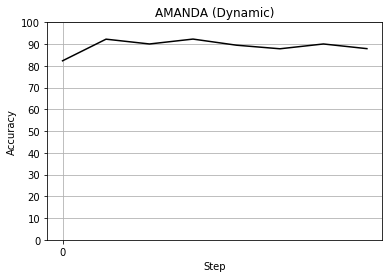

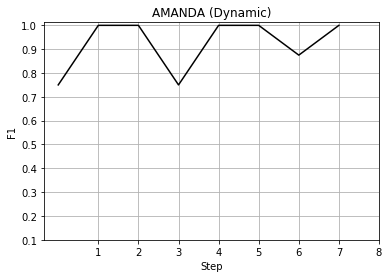




Method: SCARGC
Execution time:  20.855423266993277
Average micro-F1: 0.21875
Average Accuracy:  85.862273086
Standard Deviation:  2.78540614411
Variance:  7.75848738767


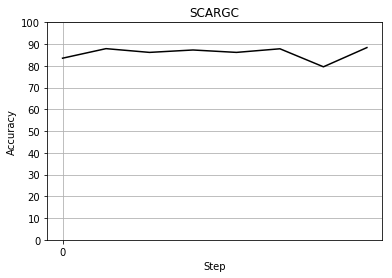

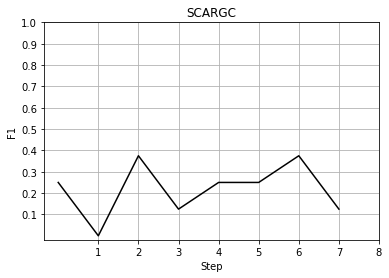

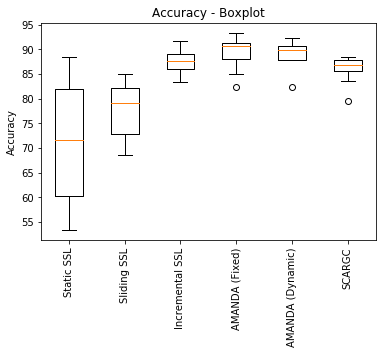

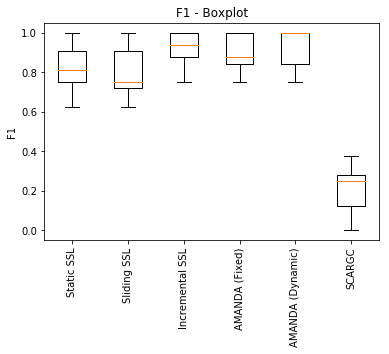

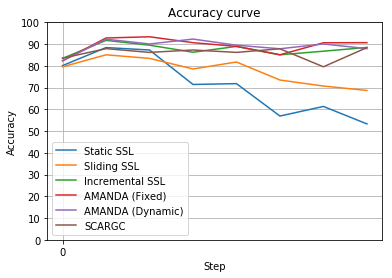

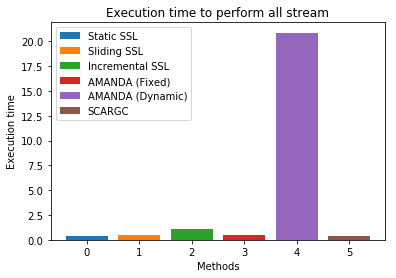

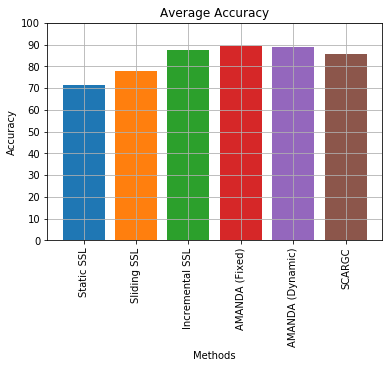

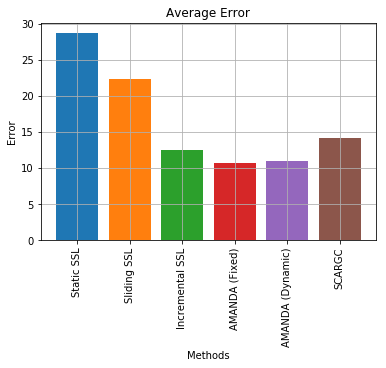

Error reduction: 8.88553952926
Error reduction: 22.702816383
Error reduction: 25.2160044866
Error reduction: 24.8321912406
Error reduction: 20.3838456139


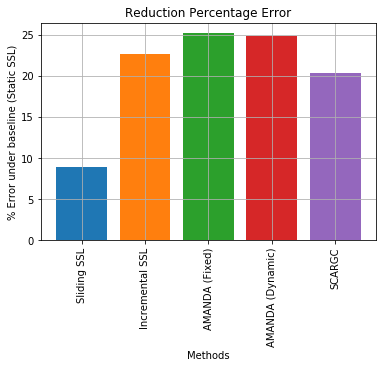

In [1]:
import sys
import os
from pathlib import Path
os.chdir(Path(os.getcwd()).resolve().parents[3])

import setup
from methods import runExperiments
from methods import static_classifier
from methods import amanda_dynamic
from methods import amanda_fixed
from methods import incremental_LN
from methods import deslizante_LN
from methods import scargc_1NN
import numpy as np


class Experiment():
     def __init__(self, method, K=None, excludingPercentage=None, densityFunction=None, clfName=None):
        self.method = method
        self.clfName = clfName
        self.densityFunction=densityFunction
        self.excludingPercentage = excludingPercentage
        self.K_variation = K

        
def accSCARGC(path, sep, key, steps):
    resultsSCARGC_1, resultsSCARGC_2 = setup.loadSCARGCBoxplotResults(path, sep)
    results = resultsSCARGC_1[key]
    res = [ results[i::steps] for i in range(steps) ]
    arrAcc = []
    for i in range(steps):
        arrAcc.append(sum(res[i])/len(res[i])*100)
    return arrAcc, results


#only for binary classification
def labelSCARGC(resultsSCARGC, true_labels):
    predictions = []
    true_labels = np.array(true_labels)
    true_labels = true_labels.flatten()
    #print(true_labels)
    for i in range(len(true_labels)):
        if resultsSCARGC[i] == 1:
            predictions.append(true_labels[i])
        else:
            if true_labels[i] == 0:
                predictions.append(1)
            else:
                predictions.append(0)
    return predictions


def main():
    experiments = {}
    is_windows = sys.platform.startswith('win')
    sep = '\\'

    if is_windows == False:
        sep = '/'

    path = os.getcwd()+sep+'data'+sep
    
    # SETTINGS
    sslClassifier = 'knn' # lp = label propagation, rf = random forests, cl = cluster and label, knn = k-nn, svm = svm
    steps = 8
    poolSize = 150
    isBatchMode = False # False = Stream
    isBinaryClassification = False
    isImbalanced = False
    externalResults = []
    
    # Load dataset
    dataValues, dataLabels, description = setup.loadKeystroke(path, sep)
    
    # Only 5% of initial labeled data - Extreme verification latency scenario
    labeledData = 150#int(0.05*len(dataLabels))

    # Static SSL
    experiments[0] = Experiment(static_classifier, 2, clfName=sslClassifier)
    
    # Sliding SSL
    experiments[1] = Experiment(deslizante_LN, 2, clfName=sslClassifier)
    
    # Incremental SSL
    experiments[2] = Experiment(incremental_LN, 2, clfName=sslClassifier)
    
    # Proposed Method 1 (AMANDA - Fixed core extraction percentage)
    experiments[3] = Experiment(amanda_fixed, 2, 0.9, "kde", sslClassifier)

    # Proposed method 2 (AMANDA - Dynamic core extraction percentage)
    experiments[4] = Experiment(amanda_dynamic, 2, None, "kde", sslClassifier)

    # SCARGC 1NN (Python version)
    #experiments[5] = Experiment(scargc_1NN, 12)
    
    arrAccSCARGC, predictionsSCARGC = accSCARGC(path, sep, 'keystroke', steps)
    predictionsSCARGC = labelSCARGC(predictionsSCARGC, dataLabels[labeledData:])
    arrPredictionsSCARGC = [ predictionsSCARGC[i::steps] for i in range(steps) ]
    externalResults.append({"name":"SCARGC", "predictions":arrPredictionsSCARGC, "accuracies":arrAccSCARGC, "time":0.36})
    
    # Run experiments
    runExperiments.run(dataValues, dataLabels, description, isBinaryClassification, isImbalanced, 
                       experiments, steps, labeledData, isBatchMode, poolSize, externalResults)
    

if __name__ == "__main__":
    main()